# Using Natural Language to Predict Programming Languange 
## Webscraping and Natural Language Processing Project 
### Presented by Chris Everts, Randy French, and Malachi Hale

## Executive Summary 

### Project Goal

For this project, we will be scraping data from GitHub repository README files. The goal will be to build a model that can predict what programming language a repository is, given the text of the README file.

### Outline 

We take the following steps: 

 - **Acquire** the text data from GitHub READme files utilizing the GitHub API. 
 - **Prepare** the data:
 
     - *First* by dropping unneeded information in the data set:
     
         - eliminating all image formatting text inside of angle brackets, 
         - eliminating all URL links from the text data, 
         - dropping rows with null values, 
         - eliminating rows with text in non-Roman characters, and
         - selecting only the eliminates whose language is within the top four most common languages.
         
     - *Second* we clean the remaining data by:
          - Performing a basic "data cleaning" through converting all text to lower case, normalize unicode strings, encoding/removing ASCII, and eliminating all foreign characters. 
          - Tokenizing the text data. 
          - Creating additional columns of stemmed data and lemmatized data. 
     
 - **Explore** the text data by addressing the following questions: 
    - What are the most common words in READme files?
    - Does the length of the READme file vary by programming language?
    - Do different programming languages use a different number of unique words?
    - What does the distribution of IDFs look like for the most common words?
    
 - **Model** the data to classify based on programming language based on the READme file text.
     - We use the classification models Naive Bayes, SVC, Decision Tree, Random Forest, K Nearest Neighbors, and Logistic Regression. 
     - We run each of these models on the stemmed data, the lemmatized data, and the cleaned data. 
     - Based on the accuracy score on the validate dataset, we choose the best model to run on the test dataset.
     
### Key Findings

We will demonstrate that we can use the K Nearest Neighbors model on the cleaned text data to predict with an accuracy greater than baseline the programming language that corresponds to each READme file. 

### Recommendation 

We were able to create a successful model that predicted better than baseline which programming language a READme file was likely to accompany. There are, however, some ways that we may be able to fortify our model.

In this project, we began with an initial dataset of 200 READme files. To make our model even more robust in the future, we may explore using a larger sample of READme files. 

Furthermore, because natural language differs so signficantly by geographic location, it may be useful to build separate classification models based on the repository creator's location. 

## Import Libraries

In [1]:
#Pandas
import pandas as pd

#Imports for web scraping and text formatting
import re
import requests
from bs4 import BeautifulSoup
import unicodedata
import json

#Stats 
from scipy import stats 

#Numpy
import numpy as np

#Import repository files
import explore 
import prepare  
import acquire  
import model as m

#Merge
from mergedeep import merge

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

# imports for modeling
from sklearn.model_selection import train_test_split

#Sparse Matrix Vectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression

# imports for visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm # for colormap tools
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import seaborn as sns


plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
plt.style.use('seaborn-darkgrid')

## Acquire

We wil utilize the GitHub API to scrape and extract the text of READme files for each page, as welll as the primary language of the reporistory. Please see the `acquire.py` file in this repository for more information on our acquire process.

In [14]:
#Use the scrape github function from the acquire module to acquire the dataframe containing the names of the
#repositories and the contents of the readme files
df = acquire.scrape_github_data()

#convert the data into a dataframe
df = pd.DataFrame(df)
df.head()

,repo,language,readme_contents
0,gongdelu/E-commerce-Customer-service-robot,Jupyter Notebook,# E-commerce-Customer-service-robot\n电商多轮对话客服机...
1,Azure/fta-customerfacingapps,C#,# FastTrack for Azure\n\nSee our [FastTrack fo...
2,ELMAHDI-AR/CustomerAuthentication-With-ASP.NET...,PowerShell,
3,kpei/Customer-Analytics,Jupyter Notebook,# Customer Analytics iPython Notebook\nSee htt...
4,Sylius/CustomerOrderCancellationPlugin,PHP,> :warning: **BEWARE!**\n> This repository has...


In [15]:
# read in the json file generated by compiling the acquire.py file
df = pd.read_json('data2.json')

In [16]:
len(df)

200

In [17]:
df.head()

,repo,language,readme_contents
0,gongdelu/E-commerce-Customer-service-robot,Jupyter Notebook,# E-commerce-Customer-service-robot\n电商多轮对话客服机...
1,Azure/fta-customerfacingapps,C#,# FastTrack for Azure\n\nSee our [FastTrack fo...
2,ELMAHDI-AR/CustomerAuthentication-With-ASP.NET...,PowerShell,
3,kpei/Customer-Analytics,Jupyter Notebook,# Customer Analytics iPython Notebook\nSee htt...
4,Sylius/CustomerOrderCancellationPlugin,PHP,> :warning: **BEWARE!**\n> This repository has...


## Prepare

To prepare our data, we will perform two tasks. First, we will drop unneeded rows in our dataset. Second, we will clean the text, as well as create columns for stemmed and lemmatized text data. For more information about our data preparation process, please see the `prepare.py` file in this repository. 

In [18]:
# do drop unneeded data first then prep
df = prepare.drop_unneeded_data(df)

In [19]:
len(df)

136

We have eliminated 64 rows from our dataset. Now we are ready to clean, stem, and lemmatize the text data.

In [20]:
df = prepare.prepare_nlp_data(df, content = 'readme_contents')

In [21]:
df.head()

,repo,language,readme_contents,clean,stemmed,lemmatized
0,gongdelu/E-commerce-Customer-service-robot,Jupyter Notebook,EcommerceCustomerservicerobot SeqSeqGRUGRU...,ecommercecustomerservicerobot seqseqgrugruteac...,ecommercecustomerservicerobot seqseqgrugruteac...,ecommercecustomerservicerobot seqseqgrugruteac...
1,kpei/Customer-Analytics,Jupyter Notebook,Customer Analytics iPython Notebook See,customer analytics ipython notebook see,custom analyt ipython notebook see,customer analytics ipython notebook see
2,Sylius/CustomerOrderCancellationPlugin,PHP,warning BEWARE This repository has been depr...,warning beware repository deprecated maintaine...,warn bewar repositori deprec maintain evolv sy...,warning beware repository deprecated maintaine...
3,optiflow/rfm-customer-segmentation,Jupyter Notebook,Recency Frequency and Monetary RFM Customer S...,recency frequency monetary rfm customer segmen...,recenc frequenc monetari rfm custom segment us...,recency frequency monetary rfm customer segmen...
4,Sylius/CustomerReorderPlugin,PHP,warning BEWARE This repository has been depr...,warning beware repository deprecated maintaine...,warn bewar repositori deprec maintain evolv sy...,warning beware repository deprecated maintaine...


## Explore

In this section, we will address the following questions: 
 - What are the most common words in READme files?
 - Does the length of the READme vary by programming language?
 - Do different programming languages use a different number of unique words?
 - What does the distribution of IDFs look like for the most common words?

### What are the most common words in READme files?

We will create a single string of our text data so that we can determine what the most frequently used words in this string are. 

In [22]:
words = ' '.join(df.stemmed)

In [23]:
words[0:1500]

'ecommercecustomerservicerobot seqseqgrugruteach forc torch jieba numpi custom analyt ipython notebook see warn bewar repositori deprec maintain evolv syliu team still use compat syliu version risk bug fix custom order cancel plugin plugin allow custom cancel place order process screenshot show custom order page cancel buttonsdocsscreenshot png busi valu far custom chang mind alreadi place order administr cancel order howev ask question cant custom cancel order yet paid come custom order cancel plugin allow cancel unpaid order straight order histori view instal bewar instal instruct assum your use symfoni flex dont take look legaci instal instructiondocslegacyinstal md howev strongli encourag use symfoni flex much quicker instal plugin requir compos bash compos requir syliuscustomerordercancellationplugin rememb allow commun recip compos config extra symfoni allowcontrib true plugin instal process extens point custom order cancel plugin use order entiti deriv syliuscorebundl well alrea

In [24]:
frequencies = pd.Series(words.split()).value_counts()

In [43]:
frequencies.head(20)

custom      923
data        424
use         407
model       258
creat       209
instal      169
project     151
file        150
run         150
featur      147
new         144
notebook    136
account     133
magento     128
set         127
segment     115
png         110
valu        107
churn       106
code        106
dtype: int64

In [26]:
top_20_words = frequencies.head(20)

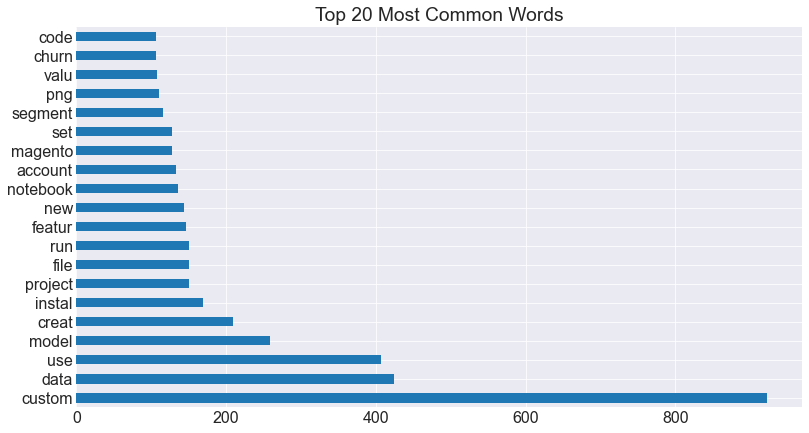

In [27]:
#Graph Most Common Words
top_20_words.plot.barh()
title = plt.title('Top 20 Most Common Words')

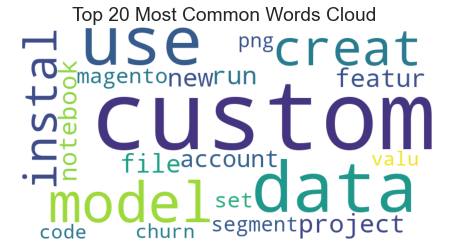

In [28]:
data = {k: v for k, v in top_20_words.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.title("Top 20 Most Common Words Cloud")
plt.show()

### Does the length of the READme file differ by programming language?

To answer this question, we will create a new column in the DataFrame for the length of each file. To create this column, we first create a list of each READme file's length.

In [29]:
#Create empty list
length_readme = []
#Loop through the DataFrame READme files
for i in range(len(df)):
    length_readme.append(len(df.readme_contents[i]))

In [30]:
#Convert list of READme lengths into DataFrame
length_readme_df = pd.DataFrame(length_readme)

In [31]:
#Merge main DataFrame and READme length DataFrame
df_with_length = pd.concat([df, length_readme_df], axis = 1)

In [32]:
df_with_length.head()

,repo,language,readme_contents,clean,stemmed,lemmatized,0
0,gongdelu/E-commerce-Customer-service-robot,Jupyter Notebook,EcommerceCustomerservicerobot SeqSeqGRUGRU...,ecommercecustomerservicerobot seqseqgrugruteac...,ecommercecustomerservicerobot seqseqgrugruteac...,ecommercecustomerservicerobot seqseqgrugruteac...,83
1,kpei/Customer-Analytics,Jupyter Notebook,Customer Analytics iPython Notebook See,customer analytics ipython notebook see,custom analyt ipython notebook see,customer analytics ipython notebook see,40
2,Sylius/CustomerOrderCancellationPlugin,PHP,warning BEWARE This repository has been depr...,warning beware repository deprecated maintaine...,warn bewar repositori deprec maintain evolv sy...,warning beware repository deprecated maintaine...,1901
3,optiflow/rfm-customer-segmentation,Jupyter Notebook,Recency Frequency and Monetary RFM Customer S...,recency frequency monetary rfm customer segmen...,recenc frequenc monetari rfm custom segment us...,recency frequency monetary rfm customer segmen...,255
4,Sylius/CustomerReorderPlugin,PHP,warning BEWARE This repository has been depr...,warning beware repository deprecated maintaine...,warn bewar repositori deprec maintain evolv sy...,warning beware repository deprecated maintaine...,2764


In [33]:
#Rename length column 
df_with_length.rename(columns = {0: "length"}, inplace = True)

In [34]:
df_with_length.head()

,repo,language,readme_contents,clean,stemmed,lemmatized,length
0,gongdelu/E-commerce-Customer-service-robot,Jupyter Notebook,EcommerceCustomerservicerobot SeqSeqGRUGRU...,ecommercecustomerservicerobot seqseqgrugruteac...,ecommercecustomerservicerobot seqseqgrugruteac...,ecommercecustomerservicerobot seqseqgrugruteac...,83
1,kpei/Customer-Analytics,Jupyter Notebook,Customer Analytics iPython Notebook See,customer analytics ipython notebook see,custom analyt ipython notebook see,customer analytics ipython notebook see,40
2,Sylius/CustomerOrderCancellationPlugin,PHP,warning BEWARE This repository has been depr...,warning beware repository deprecated maintaine...,warn bewar repositori deprec maintain evolv sy...,warning beware repository deprecated maintaine...,1901
3,optiflow/rfm-customer-segmentation,Jupyter Notebook,Recency Frequency and Monetary RFM Customer S...,recency frequency monetary rfm customer segmen...,recenc frequenc monetari rfm custom segment us...,recency frequency monetary rfm customer segmen...,255
4,Sylius/CustomerReorderPlugin,PHP,warning BEWARE This repository has been depr...,warning beware repository deprecated maintaine...,warn bewar repositori deprec maintain evolv sy...,warning beware repository deprecated maintaine...,2764


In [35]:
#Get list of unique langauges
df_with_length.language.value_counts()

Jupyter Notebook    49
PHP                 38
Python              25
JavaScript          24
Name: language, dtype: int64

In [36]:
#Create DataFrames for each language
jupyter = df_with_length[df_with_length.language == "Jupyter Notebook"]
php = df_with_length[df_with_length.language == "PHP"]
python = df_with_length[df_with_length.language == "Python"]
java = df_with_length[df_with_length.language == "JavaScript"]

In [37]:
#Reset the index of the new DataFrames 
jupyter = jupyter.reset_index()
php = php.reset_index()
python = python.reset_index()
java = java.reset_index()

In [38]:
#Calculate median and average lengths for each DataFrame
dataframes = [jupyter, php, python, java]
for lang in dataframes:
    print(lang.language[0])
    print("Median READme length", lang.length.median())
    print("Mean READme length", lang.length.mean())
    print(" ")

Jupyter Notebook
Median READme length 1644.0
Mean READme length 3242.938775510204
 
PHP
Median READme length 746.5
Mean READme length 1439.4736842105262
 
Python
Median READme length 644.0
Mean READme length 1579.96
 
JavaScript
Median READme length 1107.5
Mean READme length 2354.375
 


Now we will run statistical testing to determine if the average length of the READme file for each language is significantly different than the length of the READme file for other languages.

As is customary, for the following statistical tests, our alpha value will be 0.05.

In [39]:
not_jupyter = [php, python, java]
for lang in not_jupyter:
    print(lang.language[0], "average READme length vs Jupyter average length")
    print(stats.ttest_ind(lang.length, jupyter.length))
    print(" ")

PHP average READme length vs Jupyter average length
Ttest_indResult(statistic=-1.8616184902205477, pvalue=0.06611305850967955)
 
Python average READme length vs Jupyter average length
Ttest_indResult(statistic=-1.3835831902700682, pvalue=0.17076087452026897)
 
JavaScript average READme length vs Jupyter average length
Ttest_indResult(statistic=-0.7091768908777644, pvalue=0.4805370466090102)
 


In [40]:
not_php = [python, java]
for lang in not_php:
    print(lang.language[0], "average READme length vs PHP average length")
    print(stats.ttest_ind(lang.length, php.length))
    print(" ")

Python average READme length vs PHP average length
Ttest_indResult(statistic=0.22927542200610088, pvalue=0.8194218622696456)
 
JavaScript average READme length vs PHP average length
Ttest_indResult(statistic=1.3276887891704021, pvalue=0.18931025885020386)
 


In [41]:
print("Python average READme length vs Java average length")
print(stats.ttest_ind(python.length, java.length))

Python average READme length vs Java average length
Ttest_indResult(statistic=-0.8921389809818724, pvalue=0.3768633998634675)


The above statistical tests indicate that none of the lengths of the READme files of one programming language differ signficantly from the lengths of the READme files of any other programming language. 

We can also run statistical testing comparing the length of each programming language's READme files to the overall population READme file length.

In [42]:
for lang in dataframes:
    print(lang.language[0], "READme length vs all languages READme lengths")
    print(stats.ttest_1samp(lang.length, df_with_length.length.mean()))
    print(" ")

Jupyter Notebook READme length vs all languages READme lengths
Ttest_1sampResult(statistic=1.193575271661778, pvalue=0.23851004226093867)
 
PHP READme length vs all languages READme lengths
Ttest_1sampResult(statistic=-2.4404955964402517, pvalue=0.019575195371731947)
 
Python READme length vs all languages READme lengths
Ttest_1sampResult(statistic=-1.271917776615204, pvalue=0.21558940036119228)
 
JavaScript READme length vs all languages READme lengths
Ttest_1sampResult(statistic=0.11482863002003657, pvalue=0.9095775400216792)
 


The T-Test here indicated that he length of the PHP READme files differs signficantly from the overall population READme file length.

### Do different programming languages use a different number of unique words?

To answer this question, we can first simply check how many unique words are used in each language.

In [45]:
#Get number of unique words in Jupyter Notebook READme files
jupyter_words = ' '.join(jupyter.stemmed)
jupyter_unique_words = len(set(re.findall('\w+', jupyter_words)))
jupyter_unique_words

2630

In [46]:
#Get number of unique words for PHP READme files
php_words = ' '.join(php.stemmed)
php_unique_words = len(set(re.findall('\w+', php_words)))
php_unique_words

1106

In [47]:
#Get number of unique words for Python READme files
python_words = ' '.join(python.stemmed)
python_unique_words = len(set(re.findall('\w+', python_words)))
python_unique_words

1291

In [48]:
#Get number of unique words for Java READme files
java_words = ' '.join(java.stemmed)
java_unique_words = len(set(re.findall('\w+', java_words)))
java_unique_words

1395

Yes, each languages does use a different number of unique words. To test the stastical significance of the difference of the amount of unique words per READme file per language, however, we will need to add a `unique_words` column to our dataframe.

In [49]:
#Empty list
all_words_unique = []
#Append number of unique words per READme file to list
for i in range(len(df)):
    all_words_unique.append(len(set(re.findall('\w+', df.stemmed[i]))))

In [50]:
#Convert number of unique words list into a DataFrame
words_unique_df = pd.DataFrame(all_words_unique)

In [51]:
#Concatenate main DataFrame with unique words DataFrame
df_with_unique_words = pd.concat([df, words_unique_df], axis = 1)

In [52]:
df_with_unique_words.head()

,repo,language,readme_contents,clean,stemmed,lemmatized,0
0,gongdelu/E-commerce-Customer-service-robot,Jupyter Notebook,EcommerceCustomerservicerobot SeqSeqGRUGRU...,ecommercecustomerservicerobot seqseqgrugruteac...,ecommercecustomerservicerobot seqseqgrugruteac...,ecommercecustomerservicerobot seqseqgrugruteac...,6
1,kpei/Customer-Analytics,Jupyter Notebook,Customer Analytics iPython Notebook See,customer analytics ipython notebook see,custom analyt ipython notebook see,customer analytics ipython notebook see,5
2,Sylius/CustomerOrderCancellationPlugin,PHP,warning BEWARE This repository has been depr...,warning beware repository deprecated maintaine...,warn bewar repositori deprec maintain evolv sy...,warning beware repository deprecated maintaine...,107
3,optiflow/rfm-customer-segmentation,Jupyter Notebook,Recency Frequency and Monetary RFM Customer S...,recency frequency monetary rfm customer segmen...,recenc frequenc monetari rfm custom segment us...,recency frequency monetary rfm customer segmen...,23
4,Sylius/CustomerReorderPlugin,PHP,warning BEWARE This repository has been depr...,warning beware repository deprecated maintaine...,warn bewar repositori deprec maintain evolv sy...,warning beware repository deprecated maintaine...,143


In [57]:
#Rename unique words column
df_with_unique_words.rename(columns = {0: "unique_words"}, inplace = True)

In [58]:
#Create DataFrames for each programming language
jupyter = df_with_unique_words[df_with_unique_words.language == "Jupyter Notebook"]
php = df_with_unique_words[df_with_unique_words.language == "PHP"]
python = df_with_unique_words[df_with_unique_words.language == "Python"]
java = df_with_unique_words[df_with_unique_words.language == "JavaScript"]

In [59]:
#Reset index of the new DataFrames
jupyter = jupyter.reset_index()
php = php.reset_index()
python = python.reset_index()
java = java.reset_index()

We will now run a T-test comparing the amount of unique words per READme file per programming language to the amount of unique words per READme file in other languages.

As usual, for the following stastical tests, we will set our alpha value equal to 0.05.

In [60]:
not_jupyter = [php, python, java]
for lang in not_jupyter:
    print(lang.language[0], "average unique words vs Jupyter average unique words")
    print(stats.ttest_ind(lang.unique_words, jupyter.unique_words))
    print(" ")

PHP average unique words vs Jupyter average unique words
Ttest_indResult(statistic=-2.433140313673896, pvalue=0.017064510499042333)
 
Python average unique words vs Jupyter average unique words
Ttest_indResult(statistic=-1.6128187626187684, pvalue=0.11115882462933681)
 
JavaScript average unique words vs Jupyter average unique words
Ttest_indResult(statistic=-0.7889065178819505, pvalue=0.43279310141216065)
 


In [61]:
not_php = [python, java]
for lang in not_php:
    print(lang.language[0], "average unique words vs PHP average unique words")
    print(stats.ttest_ind(lang.unique_words, php.unique_words))
    print(" ")

Python average unique words vs PHP average unique words
Ttest_indResult(statistic=0.4580777078010558, pvalue=0.6485243059897029)
 
JavaScript average unique words vs PHP average unique words
Ttest_indResult(statistic=1.8137204264009048, pvalue=0.07472229430094941)
 


In [62]:
print("Python average unique words vs Java average unique words")
print(stats.ttest_ind(python.unique_words, java.unique_words))

Python average unique words vs Java average unique words
Ttest_indResult(statistic=-0.9490050476017465, pvalue=0.34747246057657355)


Our testing indicated that PHP and Jupyter Notebook use a stastically significant different amount of unique words in their READme files.

We can also compare the amount of unique words of the READme files of each language to the overall population unique words.

In [63]:
dataframes = [jupyter, php, python, java]
for lang in dataframes:
    print(lang.language[0], "unique words vs all languages unique words")
    print(stats.ttest_1samp(lang.unique_words, df_with_unique_words.unique_words.mean()))
    print(" ")

Jupyter Notebook unique words vs all languages unique words
Ttest_1sampResult(statistic=1.4898071344052946, pvalue=0.14281701172334046)
 
PHP unique words vs all languages unique words
Ttest_1sampResult(statistic=-3.4211473401817645, pvalue=0.0015350607370688137)
 
Python unique words vs all languages unique words
Ttest_1sampResult(statistic=-1.1020450367274606, pvalue=0.28137148824009134)
 
JavaScript unique words vs all languages unique words
Ttest_1sampResult(statistic=0.25732548982471065, pvalue=0.799215716548088)
 


Only PHP uses a signficantly different amount of unique words in its READme files than the overall population.

### What does the distribution of IDFs look like for the most common words?

Recall that we calculated the top 20 most common words in the first question of this section.

In [64]:
top_20_words

custom      923
data        424
use         407
model       258
creat       209
instal      169
project     151
file        150
run         150
featur      147
new         144
notebook    136
account     133
magento     128
set         127
segment     115
png         110
valu        107
churn       106
code        106
dtype: int64

In [65]:
#Convert top 20 words into list 
top_20_list = top_20_words.index.to_list()

Now we can calculate the IDF of the most common words. We utilize the following function to calculate IDF values.

In [67]:
# A simple way to calculate idf for demonstration. Note that this
# function relies on the globally defined documents variable.
def idf(word):
    n_occurences = sum([1 for doc in values_stemmed.values() if word in doc])
    return len(values_stemmed) / n_occurences

We also need to calculate all our stemmed values to compare to our most frequent values.

In [69]:
values_stemmed = df.stemmed.to_dict()

In [70]:
# put the unique words into a data frame
most_common_words_idf = (pd.DataFrame(dict(word=top_20_list))
 # calculate the idf for each word
 .assign(idf=lambda df: df.word.apply(idf))
 # sort the data for presentation purposes
 .set_index('word')
 .sort_values(by='idf', ascending=False)
 .head(20))

In [71]:
most_common_words_idf

,idf
word,
png,8.000000
churn,7.555556
segment,6.181818
magento,5.913043
notebook,4.857143
account,4.857143
model,4.121212
featur,4.121212
new,3.487179


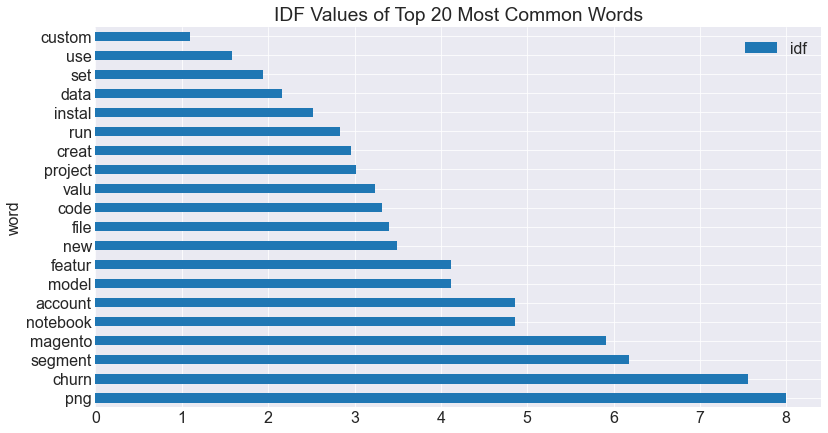

In [72]:
#Plot IDF of most common words
most_common_words_idf.plot.barh()
title = plt.title('IDF Values of Top 20 Most Common Words')

## Modeling

As is good practice, we split the data into train validate, and test datasets.